# DL Assignment 2
## Contributor:
- Abhimanyu Gupta (2019226)
- Meenal Gurbaxani (2019434)

# PART 1: Convolution Neural Network (CNN)

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import pickle

In [108]:
root_folder = '/content/drive/MyDrive/DL_Assignments/DL_A2/'
plots_location = os.path.join(root_folder, 'plots')
weights_location = os.path.join(root_folder, 'weights')
data_location = os.path.join(root_folder, 'data')

In [109]:
os.chdir(root_folder)

In [110]:
parasitized_location = os.path.join(data_location, 'Parasitized')
uninfected_location = os.path.join(data_location, 'Uninfected')

In [111]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
CHANNELS = 3

## Reading Data

In [112]:
def read_photos(folder_location, corresponding_label, X, y):
    for file in os.listdir(folder_location):
        image_path = os.path.join(folder_location, file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
        image = image.astype('float32')
        image /= 255.  
        X.append(image)
        y.append(corresponding_label)

In [113]:
# X = []
# y = []

# read_photos(parasitized_location, 1, X, y)
# read_photos(uninfected_location, 0, X, y)

# X = np.array(X)
# y = np.array(y)

# indexes = np.arange(X.shape[0])
# np.random.shuffle(indexes)
# X = X[indexes]
# y = y[indexes]

In [114]:
# np.save(os.path.join(data_location, 'data_X.npy'), X)
# np.save(os.path.join(data_location, 'data_y.npy'), y)

In [115]:
X = np.load(os.path.join(data_location, 'data_X.npy'))
y = np.load(os.path.join(data_location, 'data_y.npy'))

In [116]:
print(X.shape, y.shape)

(27558, 32, 32, 3) (27558,)


In [117]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state = 42)

In [118]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(22046, 32, 32, 3) (22046,) (2756, 32, 32, 3) (2756,) (2756, 32, 32, 3) (2756,)


In [119]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

## Visualisation

In [120]:
def plot_images(X, y, cell_class, num_rows, num_cols) :
    plt.figure(1 , figsize = (15 , 9))

    num_imgs = num_rows * num_cols
    img_inds = [-1]
    for i in range(num_imgs):
        r = -1
        while r in img_inds or y[r] != cell_class:
            r = np.random.randint(0 , X.shape[0])
        img_inds.append(r)

        plt.subplot(num_rows, num_cols, i + 1)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(X[r])
        
        plt.title(f"{'Parasitized' if y[r] == 1 else 'Unifected'} : {y[r]}")
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

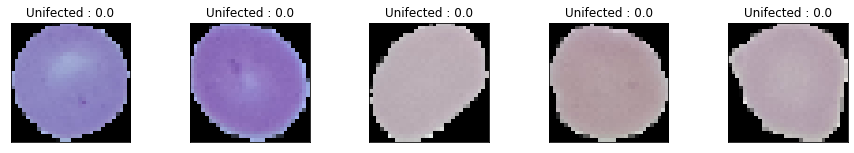

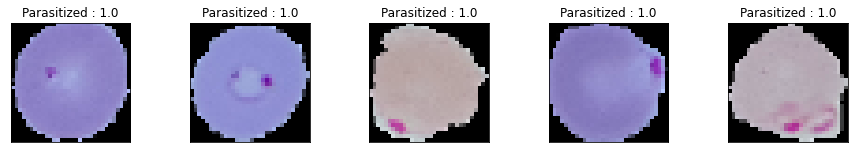

In [121]:
plot_images(X_train, y_train, 0, 1, 5)
plot_images(X_train, y_train, 1, 1, 5)

## Set up

In [122]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [123]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

## Model Creation

In [124]:
class CellImageDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = torch.Tensor(img)
        if img.shape[-1] == 3:
            img = torch.moveaxis(img, -1, 0)
        img = img.to(device)
        return {'img': img, 'label': label}

In [125]:
class Model(nn.Module):
    def __init__(self, dropout = 0, dropout_loc = None):
        super().__init__()
        self.dropout_loc = dropout_loc
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        
        self.conv1 = nn.Conv2d(3, 6, 9)
        self.bn1 = nn.BatchNorm2d(6)
        self.fc1 = nn.Linear(3456, 968)
        self.conv2 = nn.Conv2d(8, 32, 6)
        self.bn2 = nn.BatchNorm2d(32)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc2 = nn.Linear(64, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        '''
        inp -> conv1 -> relu -> bn | -> flatten -> fc -> relu -> conv2 -> relu -> bn |
                                dropout                                          dropout
        -> max_pool -> conv3 -> relu -> bn | -> flatten -> fc2 -> relu | -> sigmoid
                                        dropout                     dropout
        '''
 
        x = self.bn1(F.relu(self.conv1(x)))
        if self.dropout_loc == 'conv' :
            x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        
        x = self.bn2(F.relu(self.conv2(x.view(x.shape[0], 8, 11, 11))))
        if self.dropout_loc == 'conv' :
            x = self.dropout2(x)
        
        x = self.max_pool(x)

        x = self.bn3(F.relu(self.conv3(x)))
        if self.dropout_loc == 'conv' :
            x = self.dropout3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc2(x)
        if self.dropout_loc == 'fc' :
            x = self.dropout4(x)
        
        x = self.sig(x)
        
        return x

In [126]:
def init_zero(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
        nn.init.zeros_(model.weight)
        nn.init.zeros_(model.bias)

def init_random(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
        nn.init.normal_(model.weight, mean = 0, std = 1.0)
        nn.init.normal_(model.bias, mean = 0, std = 1.0)

def init_he(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
        nn.init.kaiming_normal_(model.weight)
        nn.init.zeros_(model.bias)

In [127]:
def regularize(model, config, num_samples):
    norm = 0
    if config['regularization'] == 'l1' :
        norm = sum(p.abs().sum() for p in model.parameters())
    elif config['regularization'] == 'l2' :
        norm = sum(p.pow(2.0).sum() for p in model.parameters())

    norm /= num_samples

    return config['lambda'] * norm

In [128]:
def get_loader(X, y, transform, config):
    cell_data = CellImageDataset(X, y, transform)
    dataloader = DataLoader(cell_data, batch_size = config['batch_size'], shuffle = True)
    return dataloader

In [129]:
def make_model(config, transform, X_train, y_train, X_val, y_val, X_test, y_test):
    loader = get_loader(X_train, y_train, transform, config)
    val_loader= get_loader(X_val, y_val, transform, config)
    test_loader= get_loader(X_test, y_test, transform, config)
    
    model = Model(dropout = config['dropout'], dropout_loc = config['dropout_loc'])
    
    if config['initialization'] == 'he':
        model.apply(init_he)
    elif config['initialization'] == 'random':
        model.apply(init_random)
    else:
        model.apply(init_zero)
    
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr = config['lr'])
    criterion = nn.BCELoss()
    
    return loader, val_loader, test_loader, model, optimizer, criterion

## Model Training

In [130]:
def track_examples_loss(tracker, example_count, examples_loss):
    examples_loss = float(examples_loss)
    tracker['examples'].append(example_count)
    tracker['examples_loss'].append(examples_loss)

In [131]:
def track_epoch_losses(tracker, epoch, epoch_loss, train_acc):
    tracker['epochs'].append(epoch)
    tracker['train_loss'].append(epoch_loss)
    tracker['train_acc'].append(train_acc)

In [132]:
def set_title(main_title, sub_title = None) :
    if sub_title is not None :
        main_title += f' ({sub_title})'
    plt.title(main_title)

In [133]:
def save_fig(save = None, save_name = None) :
    if save :
        global plots_location
        plt.savefig(f"{plots_location}/{save_name}.png")

In [134]:
def plot_examples_loss(tracker, save = False, save_name = None) :
    plt.plot(tracker['examples'], tracker['examples_loss'])
    plt.xlabel('Examples Seen')
    plt.ylabel('Loss')
    set_title('Loss vs Examples', save_name)
    save_fig(save, save_name)
    plt.show()

In [135]:
def plot_losses(tracker, save = False, save_name = None):
    plt.figure()
    plt.plot(tracker['epochs'], tracker['train_loss'], label = 'Training')
    plt.plot(tracker['epochs'], tracker['val_loss'], label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    set_title('Loss vs Epochs', save_name)
    plt.legend()
    save_fig(save, save_name)
    plt.show()

In [136]:
def plot_accuracies(tracker, save = False, save_name = None):
    plt.figure()
    plt.plot(tracker['epochs'], tracker["train_acc"], label = 'Training')
    plt.plot(tracker['epochs'], tracker["val_acc"], label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    set_title('Accuracy vs Epochs', save_name)
    plt.legend()
    save_fig(save, save_name)
    plt.show()

In [137]:
def score(model, x, y, threshold=0.5):
    with torch.no_grad():
        output = model(x)
        y_pred = output.detach().clone()
        mask = output>=threshold
        y_pred[mask] = 1
        y_pred[~mask] = 0
        accuracy = (y_pred.squeeze() == y).cpu().numpy().mean()

    return accuracy

In [138]:
def evaluate(model, loader, criterion, config):
    
    loss = 0
    example_ct = 0
    batch_ct = 0
    acc = 0

    with torch.no_grad():
        for sample in loader:
            inputs = sample['img'].to(device)
            labels = sample['label'].to(device)
            num_samples = len(inputs)
            example_ct += num_samples
            batch_ct += 1

            outputs = model(inputs)

            cur_loss = criterion(outputs.squeeze(), labels.float())
            cur_loss += regularize(model, config, num_samples)

            acc += score(model, inputs, labels)

            loss += cur_loss

        loss = loss.cpu().item()
        loss /= batch_ct
        acc /= batch_ct

    return loss, acc

In [139]:
def evaluate_validation_set(model, val_loader, criterion, tracker, config):
    
    val_loss, val_acc = evaluate(model, val_loader, criterion, config)

    tracker['val_loss'].append(val_loss)
    tracker['val_acc'].append(val_acc)

In [140]:
def evaluate_test_set(model, test_loader, criterion, tracker, config):
    
    test_loss, test_acc = evaluate(model, test_loader, criterion, config)

    print(f"Testing Accuracy is {test_acc} with loss being {test_loss}")

In [141]:
def train(model, loader, val_loader, optimizer, criterion, epochs, tracker, config):
    
    model = model.to(device)
    example_ct = 0

    for epoch in range(epochs):

        train_loss = 0
        train_acc = 0
        batch_ct = 0

        for sample in loader:
            inputs = sample['img'].to(device)
            labels = sample['label'].to(device)
            num_samples = len(inputs)
            example_ct += num_samples
            batch_ct += 1

            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), labels)
            loss += regularize(model, config, num_samples)
            
            model.eval()
            train_acc += score(model, inputs, labels)
            model.train()

            loss.backward()
            optimizer.step()

            if (batch_ct % 25) == 0:
                track_examples_loss(tracker, example_ct, loss)
                clear_output(wait = True)
                plot_examples_loss(tracker)

            train_loss += loss

        train_loss = train_loss.cpu().item()
        train_loss /= batch_ct
        train_acc /= batch_ct
        
        track_epoch_losses(tracker, epoch + 1, train_loss, train_acc)
        
        model.eval()
        evaluate_validation_set(model, val_loader, criterion, tracker, config)
        model.train()


In [142]:
class MyModel() :
    def __init__(self, config) :
        self.model = None
        self.loader = None
        self.val_loader = None
        self.optimizer = None
        self.criterion = None
        self.tracker = {
            'examples': [],
            'examples_loss': [],
            'epochs': [],
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        self.config = config

        self.maked = False
        self.trained = False
    
    def make(self, transform, X_train, y_train, X_val, y_val, X_test, y_test):
        if not self.maked :
            self.loader, self.val_loader, self.test_loader, self.model, self.optimizer, self.criterion = make_model(self.config, transform, X_train, y_train, X_val, y_val, X_test, y_test)

        self.maked = True

    def train(self) :
        assert(self.maked)
        
        train(self.model, self.loader, self.val_loader, self.optimizer, self.criterion, self.config['epochs'], self.tracker, self.config)

        self.trained = True

    def plot_examples_loss(self, save = False) :
        assert(self.trained)

        plot_examples_loss(self.tracker, True, str(self))

    def plot_losses(self, save = False) :
        assert(self.trained)

        plot_losses(self.tracker, save, str(self))
    
    def plot_accuracies(self, save = False) :
        assert(self.trained)

        plot_accuracies(self.tracker, True, str(self))

    def evaluate_testing(self) :
        assert(self.trained)

        self.model.eval()
        evaluate_test_set(self.model, self.test_loader, self.criterion, self.tracker, self.config)
        self.model.train()

    def __str__(self) :
        dropout = self.config['dropout']
        dropout_loc = self.config['dropout_loc']
        initialization = self.config['initialization']
        regularization = self.config['regularization']
        lr = self.config['lr']
        batch_size = self.config['batch_size']
        epochs = self.config['epochs']
        
        return f"{float(dropout)}_{dropout_loc}_{initialization}_{regularization}_{float(lr)}_{batch_size}_{epochs}"
    
    def save_model(self, model_name = None) :
        if model_name is None :
            model_name = f"{self}"
        global weights_location
        model_name = f"{weights_location}/{model_name}"
        with open(model_name, 'wb') as f :
            pickle.dump(self, f)

    @staticmethod
    def load_model(model_name) :
        with open(model_name, 'rb') as f :
            model = pickle.load(f)
        return model
    

In [143]:
# c = {
#     'dropout': 0,
#     'dropout_loc' : None,
#     'initialization': 'he',
#     'regularization' : None,
#     'lr': 0.002,
#     'batch_size': 32,
#     'epochs': 5,
#     'lambda' : 0
# }

# mm = MyModel(c)

# try:
#     mm = MyModel.load_model(f'{os.path.join(weights_location, str(mm))}')
# except:
#     mm.make(transform, X_train, y_train, X_val, y_val, X_test, y_test)
#     mm.train()

# mm.plot_examples_loss(True)
# mm.plot_losses(True)
# mm.plot_accuracies(True)
# mm.evaluate_testing()

# # mm.save_model()

0 0.0_None_he_None_0.002_32_10


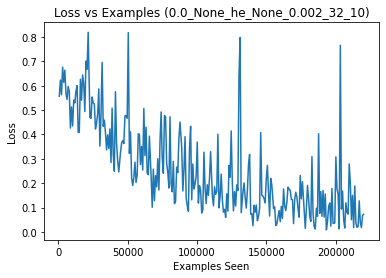

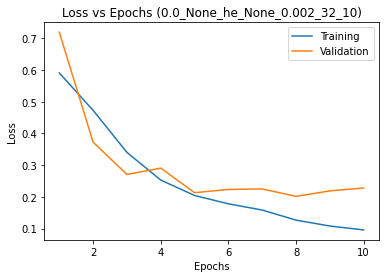

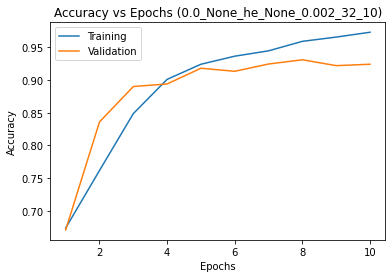

Testing Accuracy is 0.9245689655172413 with loss being 0.2288587942890737
1 0.0_None_random_None_0.002_32_10


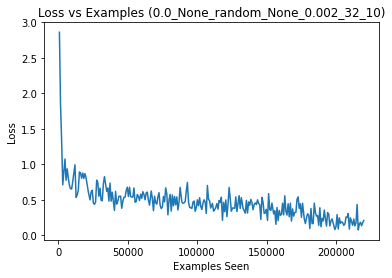

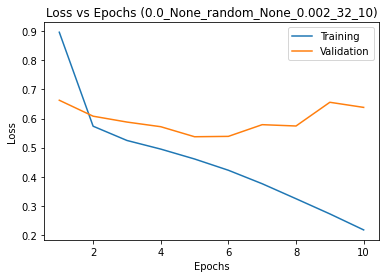

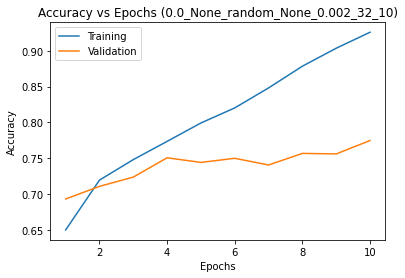

Testing Accuracy is 0.7679597701149425 with loss being 0.703735044632835
2 0.0_None_zero_None_0.002_32_10


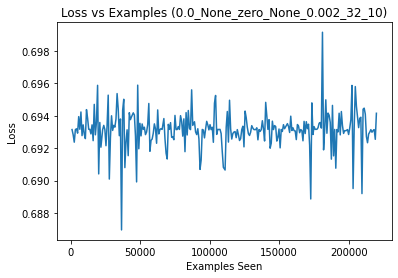

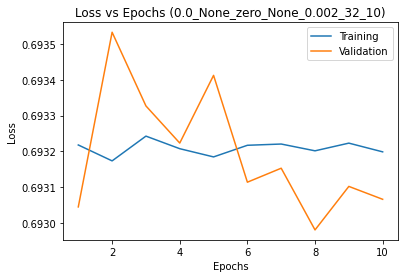

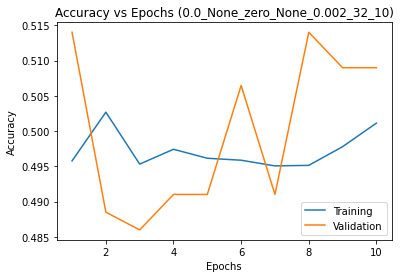

Testing Accuracy is 0.4859913793103448 with loss being 0.6933091262291218


In [144]:
configs = [ [0, None, 'he', None], [0, None, 'random', None], [0, None, 'zero', None] ]
counter = 0

for d, l, i, r in configs :

    c = {
        'dropout': d,
        'dropout_loc' : l,
        'initialization': i,
        'regularization' : r,
        'lr': 0.002,
        'batch_size': 32,
        'epochs': 10,
        'lambda' : 0
    }

    mm = MyModel(c)

    print(counter, mm)
    counter += 1

    try:
        mm = MyModel.load_model(f'{os.path.join(weights_location, str(mm))}')
    except:
        mm.make(transform, X_train, y_train, X_val, y_val, X_test, y_test)
        mm.train()

    mm.plot_examples_loss(True)
    mm.plot_losses(True)
    mm.plot_accuracies(True)
    mm.evaluate_testing()

    # mm.save_model()


0 0.0_None_he_l1_0.002_32_10


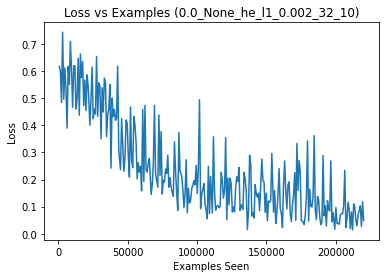

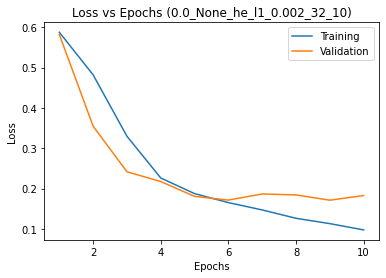

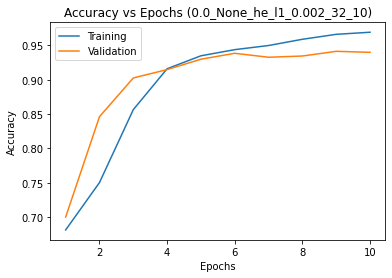

Testing Accuracy is 0.9371408045977011 with loss being 0.18853187561035156
1 0.0_None_he_l2_0.002_32_10


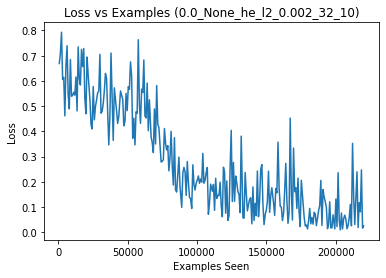

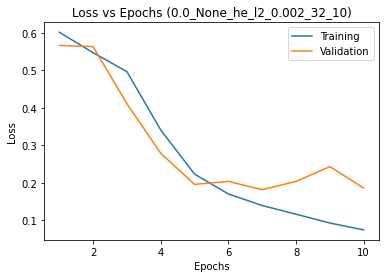

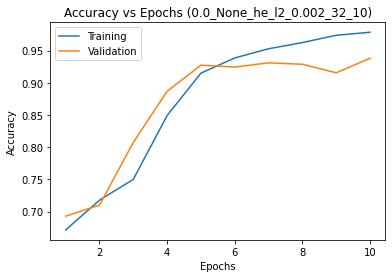

Testing Accuracy is 0.9324712643678161 with loss being 0.20611111871127424


In [146]:
configs = [ [0, None, 'he', 'l1'], [0, None, 'he', 'l2'] ]
counter = 0

for d, l, i, r in configs :

    c = {
        'dropout': d,
        'dropout_loc' : l,
        'initialization': i,
        'regularization' : r,
        'lr': 0.002,
        'batch_size': 32,
        'epochs': 10,
        'lambda' : 0
    }

    mm = MyModel(c)

    print(counter, mm)
    counter += 1

    try:
        mm = MyModel.load_model(f'{os.path.join(weights_location, str(mm))}')
    except:
        mm.make(transform, X_train, y_train, X_val, y_val, X_test, y_test)
        mm.train()

    mm.plot_examples_loss(True)
    mm.plot_losses(True)
    mm.plot_accuracies(True)
    mm.evaluate_testing()

    # mm.save_model()


0 0.2_conv_he_None_0.002_32_10


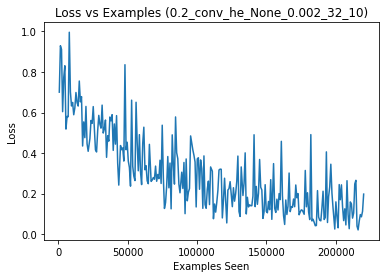

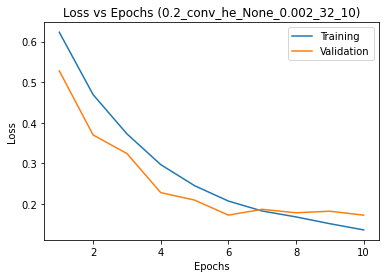

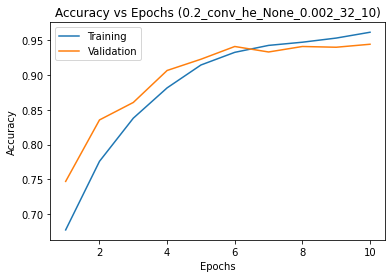

Testing Accuracy is 0.9407327586206896 with loss being 0.17067568329558974
1 0.2_fc_he_None_0.002_32_10


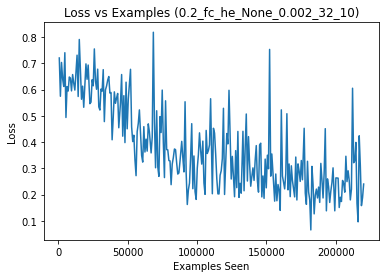

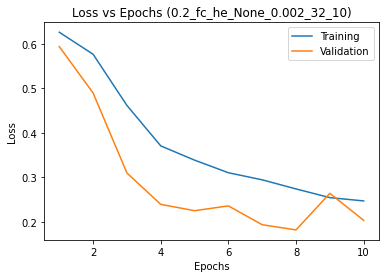

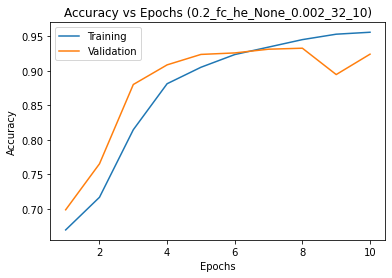

Testing Accuracy is 0.9267241379310345 with loss being 0.19685258536503233
2 0.4_conv_he_None_0.002_32_10


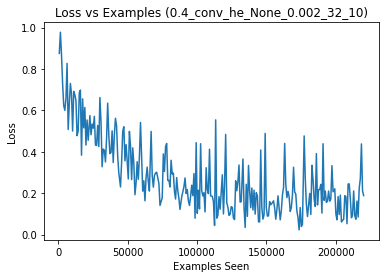

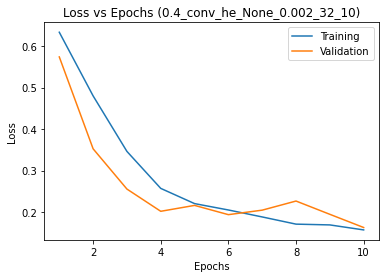

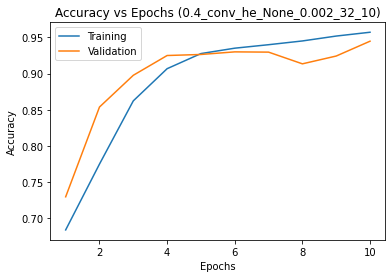

Testing Accuracy is 0.9392959770114943 with loss being 0.1593480384212801
3 0.4_fc_he_None_0.002_32_10


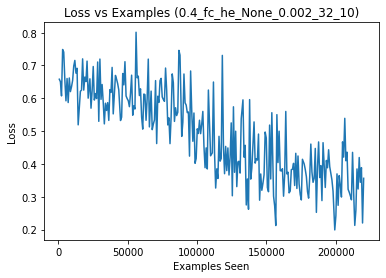

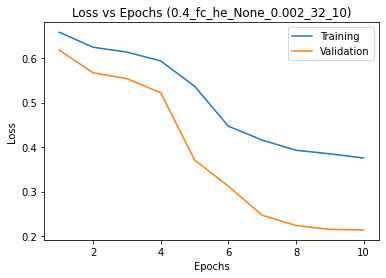

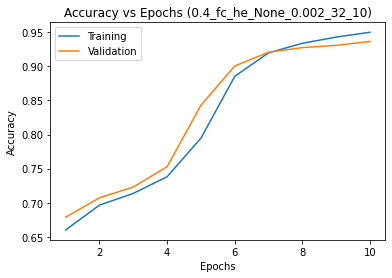

Testing Accuracy is 0.9375 with loss being 0.21425812819908405
4 0.5_conv_he_None_0.002_32_10


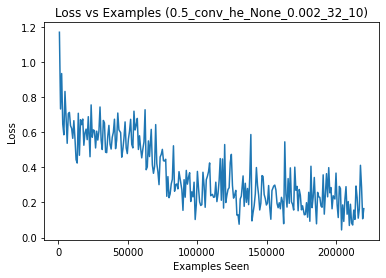

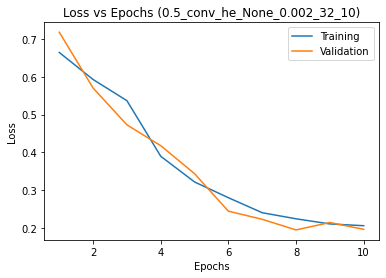

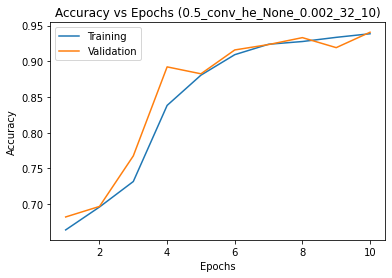

Testing Accuracy is 0.9335488505747126 with loss being 0.1931654173752357
5 0.5_fc_he_None_0.002_32_10


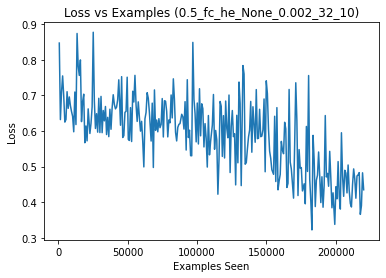

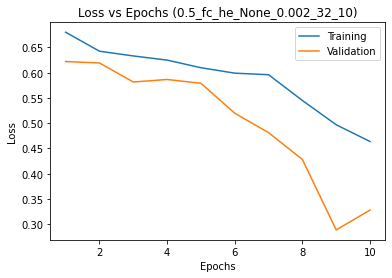

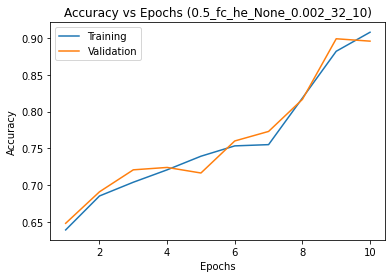

Testing Accuracy is 0.9001436781609196 with loss being 0.3183314663240279


In [147]:
configs = [ [0.2, 'conv', 'he', None], [0.2, 'fc', 'he', None], [0.4, 'conv', 'he', None], [0.4, 'fc', 'he', None], [0.5, 'conv', 'he', None], [0.5, 'fc', 'he', None] ]
counter = 0

for d, l, i, r in configs :

    c = {
        'dropout': d,
        'dropout_loc' : l,
        'initialization': i,
        'regularization' : r,
        'lr': 0.002,
        'batch_size': 32,
        'epochs': 10,
        'lambda' : 0
    }

    mm = MyModel(c)

    print(counter, mm)
    counter += 1

    try:
        mm = MyModel.load_model(f'{os.path.join(weights_location, str(mm))}')
    except:
        mm.make(transform, X_train, y_train, X_val, y_val, X_test, y_test)
        mm.train()

    mm.plot_examples_loss(True)
    mm.plot_losses(True)
    mm.plot_accuracies(True)
    mm.evaluate_testing()

    # mm.save_model()
